# ZZ Analysis


<CENTER><img src="HZZ_feynman.pdf" style="width:40%"></CENTER>

## First time setup
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close jupyter and re-open on the same computer, you won't need to run this first cell again.

If you re-open on binder, you will need to run this cell again.

If you run into a problem of "uproot not being available", Kernel -> Restart & Run All

In [1]:
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy pandas uproot matplotlib --user

Traceback (most recent call last):
  File "/Users/stan/anaconda3/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/stan/anaconda3/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/stan/.local/lib/python3.7/site-packages/pip/__main__.py", line 19, in <module>
    sys.exit(_main())
  File "/Users/stan/.local/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/Users/stan/.local/lib/python3.7/site-packages/pip/_internal/commands/__init__.py", line 96, in create_command
    module = importlib.import_module(module_path)
  File "/Users/stan/anaconda3/anaconda3/lib/python3.7/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1006, in _gcd_import
  File "<frozen importlib._boo

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [2]:
import uproot
import pandas as pd
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import glob
import infofile

In [3]:
lumi = 10064.3
                                                                                                                                  
tuple_path = "Input/"

stack_order = ['data',r'$Z,t\bar{t}$','ZZ']

In [4]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D']
    },

    r'$Z,t\bar{t}$' : {
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3"
    },
    
     'ZZ' : {
        'list' : ['llll','lllv'],     
        'color' : "#00cdff"
         
    
#    },
#
#    
#    'lllv' : {
#        'list' : ['lllv'],
#        'color' : "#FF8000"
#    },
#    
#    'llvv' : {
#        'list' : ['llvv'],
#        'color' : "#15EF3A"
#    },
#    
#    'lvvv' : {
#        'list' : ['lvvv'],
#        'color' : "#ff0000"
    }


}

In [5]:
def get_data_from_files(cutval=0):

    data = {}
    
    for s in samples:
        print(s+':')
        frames = []
        for val in samples[s]['list']:
            prefix = "MC/mc_"
            if s == 'data':
                prefix = "Data/"
            else: prefix += str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val
            if len(fileString)==17:
                fileString=fileString+".4lep.root"
            else:
                fileString=fileString+".4lep.root"
            f = glob.glob(fileString, recursive=False)[0]
            if f != "":
                temp = read_file(f,val,cutval)
                frames.append(temp)
            else:
                print("Error: "+val+" not found!")
        data[s] = pd.concat(frames)

    return data


In [6]:
def calc_weight(mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,
                scaleFactor_MUON, scaleFactor_LepTRIGGER):
    return mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

In [7]:
def get_xsec_weight(totalWeight,sample):
    info = infofile.infos[sample]
    weight = (lumi*info["xsec"])/(info["sumw"]*info["red_eff"])
    weight *= totalWeight
    return weight

In [8]:
def mllll_window(mllll):
    return 120 < mllll < 190

In [9]:
def plot_data(data):

    bins = [80 + x*5 for x in range(35) ]
    data_x = [82.5 + x*5 for x in range(34) ]

    data_mllll = []
    data_mllll_errors = []

    mc_mllll = []
    mc_weights = []
    mc_colors = []
    mc_labels = []
    mc_in_mllll_window = []  # list for numbers of MC events with 120 < mllll < 190 GeV

    for s in stack_order:
        if s == "data":
            data_mllll,_ = np.histogram(data[s].mllll.values, bins=bins)
            data_mllll_errors = np.sqrt(data_mllll)
        else:
            mc_labels.append(s)
            mc_mllll.append(data[s].mllll.values)
            mc_colors.append(samples[s]['color'])
            mc_weights.append(data[s].totalWeight.values)
            mc_in_mllll_window.append([data[s].totalWeight.values[mllll_iter] for mllll_iter in range(len(data[s].mllll.values)) if 120 < data[s].mllll.values[mllll_iter] < 190])
      

    ZZ_in_mllll_window = sum(mc_in_mllll_window[1]) # number signal MC events with 120 < mllll < 190 GeV
    background_in_mllll_window = sum(mc_in_mllll_window[0]) # number background MC events with 120 < mllll < 190 GeV
    SoversqrtB = ZZ_in_mllll_window/math.sqrt(background_in_mllll_window) # calculate significance
    print('Signal/sqrt(Background) for 120<mllll<190 '+str(SoversqrtB))
    
    top = np.amax(data_mllll)+math.sqrt(np.amax(data_mllll)) 

    plt.figure()
    plt.hist(mc_mllll,bins=bins,weights=mc_weights,stacked=True,color=mc_colors, label=mc_labels)
    plt.errorbar( x=data_x, y=data_mllll, yerr=data_mllll_errors, fmt='ko', label='Data')

    
    plt.xlabel(r'$M_{\ell\ell\ell\ell}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)

    plt.ylabel(r'Events',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)                                                                                                                                                                
    #plt.yscale('log')
    plt.ylim(bottom=0,top=top)

    ax = plt.gca()
    plt.text(0.05,0.97,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="top",family='sans-serif',transform=ax.transAxes,fontsize=13)
    plt.text(0.05,0.92,'for education only',ha="left",va="top",family='sans-serif',transform=ax.transAxes,style='italic',fontsize=8)
    plt.text(0.05,0.9,r'$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=3.2\,\mathrm{fb}^{-1}$',ha="left",va="top",family='sans-serif',transform=ax.transAxes)

    plt.legend()

    plt.savefig("plotZZdata.pdf")
    
    return


def plot_mll(data):

    bins = [10 + x*5 for x in range(35) ]
    data_x = [12.5 + x*5 for x in range(34) ]

    data_mll = []
    data_mll_errors = []

    mc_mll = []
    mc_weights = []
    mc_colors = []
    mc_labels = []
    mc_in_mll_window = [] # list for numbers of MC events with 66 GeV < mll < 116 GeV

    for s in stack_order:
        if s == "data":
            data_mll,_ = np.histogram(data[s].mll.values, bins=bins)
            data_mll_errors = np.sqrt(data_mll)
        else:
            mc_labels.append(s)
            mc_mll.append(data[s].mll.values)
            mc_colors.append(samples[s]['color'])
            mc_weights.append(data[s].totalWeight.values)
            mc_in_mll_window.append([data[s].totalWeight.values[mll_iter] for mll_iter in range(len(data[s].mll.values)) if 66 < data[s].mll.values[mll_iter] < 116])
    
    top = np.amax(data_mll)+math.sqrt(np.amax(data_mll))

    Z_in_mll_window = sum(mc_in_mll_window[1]) # number signal MC events with 66 < mll < 116 GeV
    background_in_mll_window = sum(mc_in_mll_window[0]) # number background MC events with 66 < mllll < 116 GeV
    SoversqrtB = Z_in_mll_window/math.sqrt(background_in_mll_window) # calculate significance
    print('Signal/sqrt(Background) for 66<mllll<116 '+str(SoversqrtB))
    
    
    plt.figure()
    plt.hist(mc_mll,bins=bins,weights=mc_weights,stacked=True,color=mc_colors, label=mc_labels)
    plt.errorbar( x=data_x, y=data_mll, yerr=data_mll_errors, fmt='ko', label='Data')

    plt.xlabel(r'$M_{\ell\ell}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)

    plt.ylabel(r'Events',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
    #plt.yscale('log')                                                                                                                                                                        
    plt.ylim(bottom=0,top=top)

    ax = plt.gca()
    plt.text(0.05,0.97,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="top",family='sans-serif',transform=ax.transAxes,fontsize=13)
    plt.text(0.05,0.92,'for education only',ha="left",va="top",family='sans-serif',transform=ax.transAxes,style='italic',fontsize=8)
    plt.text(0.05,0.9,r'$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=3.2\,\mathrm{fb}^{-1}$',ha="left",va="top",family='sans-serif',transform=ax.transAxes)

    plt.legend()

    plt.savefig("plotZZmll.pdf")
    
    return

In [10]:
def calc_mllll(lep_pts,lep_etas,lep_phis):
    theta_0 = 2*math.atan(math.exp(-lep_etas[0]))
    theta_1 = 2*math.atan(math.exp(-lep_etas[1]))
    theta_2 = 2*math.atan(math.exp(-lep_etas[2]))
    theta_3 = 2*math.atan(math.exp(-lep_etas[3]))
    p_0 = lep_pts[0]/math.sin(theta_0)
    p_1 = lep_pts[1]/math.sin(theta_1)
    p_2 = lep_pts[2]/math.sin(theta_2)
    p_3 = lep_pts[3]/math.sin(theta_3)
    pz_0 = p_0*math.cos(theta_0)
    pz_1 = p_1*math.cos(theta_1)
    pz_2 = p_2*math.cos(theta_2)
    pz_3 = p_3*math.cos(theta_3)
    px_0 = p_0*math.sin(theta_0)*math.cos(lep_phis[0])
    px_1 = p_1*math.sin(theta_1)*math.cos(lep_phis[1])
    px_2 = p_2*math.sin(theta_2)*math.cos(lep_phis[2])
    px_3 = p_3*math.sin(theta_3)*math.cos(lep_phis[3])
    py_0 = p_0*math.sin(theta_0)*math.sin(lep_phis[0])
    py_1 = p_1*math.sin(theta_1)*math.sin(lep_phis[1])
    py_2 = p_2*math.sin(theta_2)*math.sin(lep_phis[2])
    py_3 = p_3*math.sin(theta_3)*math.sin(lep_phis[3])
    sumpz = pz_0 + pz_1 + pz_2 + pz_3
    sumpx = px_0 + px_1 + px_2 + px_3
    sumpy = py_0 + py_1 + py_2 + py_3
    sumE = p_0 + p_1 + p_2 + p_3
    mllll = sumE**2 - sumpz**2 - sumpx**2 - sumpy**2
    return math.sqrt(mllll)/1000.

In [11]:
def calc_m_Z1(lep_pts,lep_etas,lep_phis,lep_charges,lep_types):
    # mass of Z boson candidate 1
    mOCST = [999.999]
    for i in range(len(lep_pts)-1):
        for j in range(len(lep_pts)-1):
            if j!=i and lep_charges[i]!=lep_charges[j] and lep_types[i]==lep_types[j]:
                mll = 2*lep_pts[i]*lep_pts[j]
                cosh = math.cosh(lep_etas[i]-lep_etas[j])
                cos = math.cos(lep_phis[i]-lep_phis[j])
                mll *= ( cosh - cos )
                mOCST.append(math.sqrt(mll)/1000.)      
    return min([mOCST-90for mOCST in mOCST])+ 90 

In [12]:
def calc_min_mOCST(lep_pts,lep_etas,lep_phis,lep_charges,lep_types):
    # same-type-opposite-flavour
    mOCST = [999.999]
    for i in range(len(lep_pts)-1):
        for j in range(len(lep_pts)-1):
            if j!=i and lep_charges[i]!=lep_charges[j] and lep_types[i]==lep_types[j]:
                mll = 2*lep_pts[i]*lep_pts[j]
                cosh = math.cosh(lep_etas[i]-lep_etas[j])
                cos = math.cos(lep_phis[i]-lep_phis[j])
                mll *= ( cosh - cos )
                mOCST.append(math.sqrt(mll)/1000.)      
    return min(mOCST)

In [13]:
def cut_d0_all(lep_type,lep_tracksigd0pvunbiased):
    #cut on d0 of all the leptons
    for i in range(len(lep_type)-1):
        if lep_type[i]==11 and lep_tracksigd0pvunbiased[i] > 6.5: return True
        elif lep_type[i]==13 and lep_tracksigd0pvunbiased[i] > 3.5: return True
        else:return False

In [14]:
def calc_m_Z2(lep_pts,lep_etas,lep_phis,lep_charges,lep_types):
    # mass of Z boson candidate 2
    mOCST = [999.999]
    for i in range(len(lep_pts)-1):
        for j in range(len(lep_pts)-1):
            if j!=i and lep_charges[i]!=lep_charges[j] and lep_types[i]==lep_types[j]:
                mll = 2*lep_pts[i]*lep_pts[j]
                cosh = math.cosh(lep_etas[i]-lep_etas[j])
                cos = math.cos(lep_phis[i]-lep_phis[j])
                mll *= ( cosh - cos )
                mOCST.append(math.sqrt(mll)/1000.)      
    return min([mOCST-34for mOCST in mOCST])+ 34 

In [15]:
def refine_m_Z2(mllll):

    if mllll <= 120: return 17.5 
    if mllll >= 190: return 50 
    if ( 120 <= mllll <= 190 ): return ((13/28)* mllll - (535/14) )

## Uncommenting a new cut
If you add a cut: Cell -> Run All Below

In [16]:
def read_file(path,sample,cutval):
    start = time.time()
    print("\tProcessing: "+sample)
    mc = uproot.open(path)["mini"]
    data = mc.pandas.df(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type",
                         "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON", # add more variables here if you make cuts on them ,  
                         "scaleFactor_LepTRIGGER","lep_tracksigd0pvunbiased"], flatten=False)

    nIn = len(data.index)
    
    

    if 'data' not in sample:
        data['totalWeight'] = np.vectorize(calc_weight)(data.mcWeight,data.scaleFactor_PILEUP,data.scaleFactor_ELE,data.scaleFactor_MUON,data.scaleFactor_LepTRIGGER)
        data['totalWeight'] = np.vectorize(get_xsec_weight)(data.totalWeight,sample)
       

    data.drop(["mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_LepTRIGGER"], axis=1, inplace=True)
        
        
    # cut on number of leptons
    fail =data[ np.vectorize(cut_n_lep)(data.lep_n)].index
    data.drop(fail, inplace=True)
    
    # cut on lepton charge
    fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
    data.drop(fail, inplace=True)
    
    #cut on the transverse momentum of the leptons
    fail =data[ np.vectorize(cut_lep_pt_012)(data.lep_pt)].index
    data.drop(fail,inplace=True)
    
    # cut on lepton type
    fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
    data.drop(fail, inplace=True)
    
    fail =data[ np.vectorize(cut_lep_eta)(data.lep_eta)].index
    data.drop(fail, inplace=True)
    
    # cut on pseudrapidity of electrons and muons 
    fail =data[ np.vectorize(cut_lep_eta2)(data.lep_eta,data.lep_type)].index
    data.drop(fail, inplace=True)
    
     # cut on minimum opposite-charge-same-type lepton pair invariant mass
    fail =data[ np.vectorize(calc_min_oppositecharge)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_charge,data.lep_type)].index
    data.drop(fail, inplace=True)
   
    # calculation of Z boson candidate 1 invariant mass upper limit 
    fail =data[ np.vectorize(cut_mu_Z1)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_charge,data.lep_type)].index
    data.drop(fail, inplace=True)
    
    # calculation of Z boson candidate 1 invariant mass lower limit
    fail =data[ np.vectorize(cut_m_Z_1)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_charge,data.lep_type)].index
    data.drop(fail, inplace=True)
    
    # cut on lepton d0
    fail =data[ np.vectorize(cut_lep_tracksigd0pvunbiased)(data.lep_tracksigd0pvunbiased,data.lep_type)].index
    data.drop(fail, inplace=True)
    
    # calculation of 4-lepton invariant mass
    data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi)
    
    #cut on invariant mass of Z boson candidate 2 min
    fail =data[ np.vectorize(cut_Z_boson2)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_charge,data.lep_type)].index
    data.drop(fail, inplace=True)
    #fail =data[ np.vectorize(cut_Z_boson2)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_charge,data.lep_type,data.mllll)].index
    #data.drop(fail, inplace=True)
    
    #cut on invariant mass of Z boson candidate max
    fail =data[ np.vectorize(cut_Z_boson_2upper)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_charge,data.lep_type)].index
    data.drop(fail, inplace=True)
    
    # calculation of the 2-lepton invariant mass
    data['mll'] = np.vectorize(calc_m_Z1)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_charge,data.lep_type)
    
    nOut = len(data.index)

    elapsed = time.time() - start
    print("\t\tTime taken: "+str(elapsed)+", nIn: "+str(nIn)+", nOut: "+str(nOut))
    
    return data

## Changing an already uncommented cut

If you change a cut: Cell -> Run All Below

If you uncomment a cut here, you also need to uncomment the corresponding cut in the cell above.

In [17]:
# cut on number of leptons
def cut_n_lep(lep_n):
    # exclamation mark (!) means "not"
    # so != means "not equal to"
    # return when number of leptons is not equal to 4 
    return lep_n != 4

# cut on lepton charge
def cut_lep_charge(lep_charge):
    # return when sum of lepton charges is not equal to 0
    # first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

#cut on transverse momentum of the leptons
def cut_lep_pt_012(lep_pt):
#want to throw away any events where lep_pt [0] < 20000
#want to throw away any events where lep_pt [1] < 20000
#want to throw away any events where lep_pt [2] < 20000
#want to throw away any events where lep_pt [2] < 20000
    return lep_pt[0] < 20000 or lep_pt[1] < 20000 or lep_pt[2] < 20000 or lep_pt[3] < 20000

# cut on lepton type
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)

# Cut on pseudorapidity 1
def cut_lep_eta(lep_eta):
#want to discard any events where lep_eta > 2.7
    return lep_eta[0] > 2.7 or lep_eta[1] > 2.7 or lep_eta[2] > 2.7 or lep_eta[3] > 2.7 or lep_eta[0] < -2.7 or lep_eta[1] < -2.7 or lep_eta[2] < -2.7 or lep_eta[3] < -2.7  

# Cut on pseudorapidity 2
def cut_lep_eta2(lep_eta, lep_type):
#want to discard any events where electrons lep_eta > 2.47, and where one of the muons in four muon channel 
#has lep_eta > 2.4 while all other muons have lep_eta > 2.7 
    for i in range(len(lep_type)-1):
        if lep_type[i] == 11:
            return lep_eta[i] > 2.47 or lep_eta[i] < -2.47        
        if lep_type[0] == 13 and lep_type[1] == 13 and lep_type[2] == 13 and lep_type[3] == 13 :
            if lep_eta[0] > 2.4 and lep_eta[1] > 2.7 and lep_eta[2] > 2.7 and lep_eta[3] > 2.7: return True 
            elif lep_eta[0] < -2.4 and lep_eta[1] < -2.7 and lep_eta[2] < -2.7 and lep_eta[3] < -2.7: return True
            elif lep_eta[0] > 2.7 and lep_eta[1] > 2.4 and lep_eta[2] > 2.7 and lep_eta[3] > 2.7: return True
            elif lep_eta[0] < -2.7 and lep_eta[1] < -2.4 and lep_eta[2] < -2.7 and lep_eta[3] < -2.7: return True
            elif lep_eta[0] > 2.7 and lep_eta[1] > 2.7 and lep_eta[2] > 2.4 and lep_eta[3] > 2.7: return True
            elif lep_eta[0] < -2.7 and lep_eta[1] < -2.4 and lep_eta[2] < -2.4 and lep_eta[3] < -2.7: return True
            elif lep_eta[0] > 2.7 and lep_eta[1] > 2.7 and lep_eta[2] > 2.7 and lep_eta[3] > 2.4: return True
            elif lep_eta[0] < -2.7 and lep_eta[1] < -2.4 and lep_eta[2] < -2.7 and lep_eta[3] < -2.4: return True
            else: return False 

#cut on minimium opposite charge same type lepton pair invariant mass
def calc_min_oppositecharge(lep_pt,lep_eta,lep_phi,lep_charge,lep_type):
#return any events where mass < 5
    return calc_min_mOCST(lep_pt,lep_eta,lep_phi,lep_charge,lep_type) < 66
 
# cut on invariant mass of a Z boson candidate 1 upper limit 
def cut_mu_Z1(lep_pt,lep_eta,lep_phi,lep_charge,lep_type):
# want invariant mass of same-type-opposite-charge lepton pair that's closest to Z mass (91 GeV) to be  m < 116 GeV
    return calc_m_Z1(lep_pt,lep_eta,lep_phi,lep_charge,lep_type)> 116

# cut on invariant mass of Z boson candidate 1 lower limit
def cut_m_Z_1(lep_pt,lep_eta,lep_phi,lep_charge,lep_type):
# want invariant mass of same-type-opposite-charge lepton pair that's closest to Z mass (91 GeV) to be 66 < m
    return calc_m_Z1(lep_pt,lep_eta,lep_phi,lep_charge,lep_type)< 66

# cut on lepton d0
def cut_lep_tracksigd0pvunbiased(lep_tracksigd0pvunbiased,lep_type):
#want to throw away any events where the lepton d0 signifigance for electrons > 6.5
#want to throw away any events where the lepton d0 signifigance for muons > 3.5
    return cut_d0_all(lep_type,lep_tracksigd0pvunbiased)

#cut on invariant mass of Z boson candidate 2 min
def cut_Z_boson2(lep_pt,lep_eta,lep_phi,lep_charge,lep_type):
    return calc_m_Z2(lep_pt,lep_eta,lep_phi,lep_charge,lep_type)< 66
# return calc_m_Z2(lep_pt,lep_eta,lep_phi,lep_charge,lep_type)< refine_m_Z2(mllll)

#cut on invariant mass of Z boson candidate max
def cut_Z_boson_2upper(lep_pt,lep_eta,lep_phi,lep_charge,lep_type):
    return calc_m_Z2(lep_pt,lep_eta,lep_phi,lep_charge,lep_type) > 116 

    

data:
	Processing: data_A
		Time taken: 0.06759810447692871, nIn: 39, nOut: 7
	Processing: data_B
		Time taken: 0.06567502021789551, nIn: 156, nOut: 20
	Processing: data_C
		Time taken: 0.05702090263366699, nIn: 237, nOut: 39
	Processing: data_D
		Time taken: 0.0738990306854248, nIn: 400, nOut: 75
$Z,t\bar{t}$:
	Processing: Zee
		Time taken: 0.06833314895629883, nIn: 898, nOut: 5
	Processing: Zmumu
		Time taken: 0.10094618797302246, nIn: 684, nOut: 1
	Processing: ttbar_lep
		Time taken: 0.07836699485778809, nIn: 1031, nOut: 1
ZZ:
	Processing: llll
		Time taken: 38.49347710609436, nIn: 554279, nOut: 208316
	Processing: lllv
		Time taken: 0.2758810520172119, nIn: 9340, nOut: 135
Signal/sqrt(Background) for 120<mllll<190 13.792988098872174
Time taken: 40.85373902320862
Signal/sqrt(Background) for 66<mllll<116 104.42507619160297


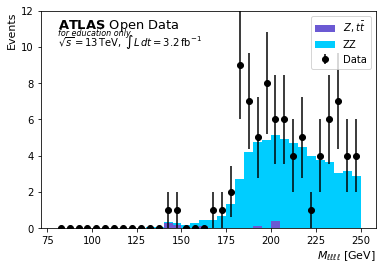

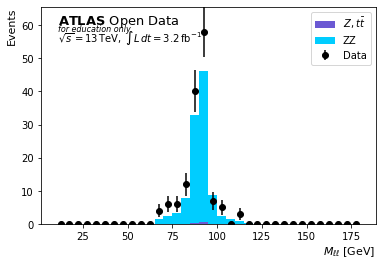

In [18]:
if __name__=="__main__":
    start = time.time()
    
    cutmin=0
    cutmax=1
    
    for c in range(cutmin,cutmax):
        data = get_data_from_files()
    
    plot_data(data)
    elapsed = time.time() - start
    print("Time taken: "+str(elapsed))
    
    plot_mll(data)